# Learn with Linear Model

Use a linear model to learn weights for draco. 

In [1]:
from draco.learn import linear

%config InlineBackend.figure_format = 'retina'

Train score:  1.0
Dev score:  0.9978471474703983


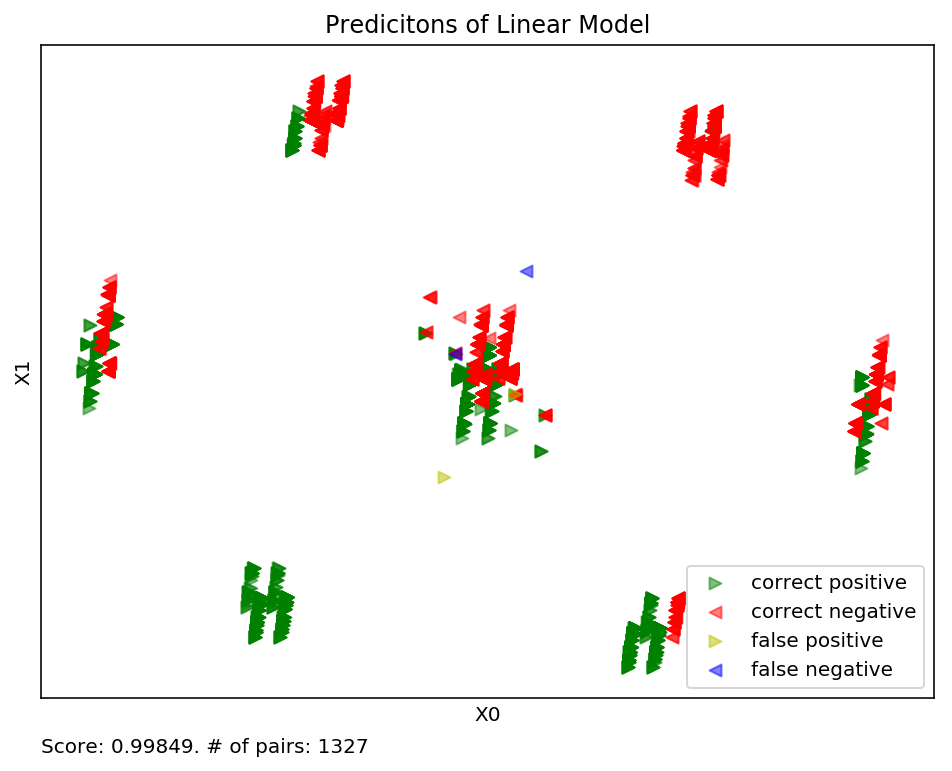

CPU times: user 4.48 s, sys: 1.84 s, total: 6.33 s
Wall time: 6.18 s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='sag', tol=0.0001,
          verbose=0, warm_start=False)

In [2]:
%time linear.main()